In [1]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
#     * Bar graph: Top facilities with most complaints
#     * Bar graph: Top facilities with most fines
#     * Bar graph: Fines per year before and after Trump
#     * Scatter plot 
#     * Map cities with most deficiencies QGIS

In [3]:
!ls

Nursing Homes in Texas.ipynb        penaltiestest.xlsx
images                              simple.html
index.html                          styles
inspection reports per facility.csv ~$penaltiestest.xlsx
nursing homes penalties.csv


In [4]:
df2 = pd.read_csv("inspection reports per facility.csv")

# Filter Texas Deficiencies

In [5]:
texas_deficiencies = df2[(df2['state'] == 'TX')]

In [6]:
texas_deficiencies.shape

(26840, 13)

In [7]:
texas_deficiencies.head()

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text
17739,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,441,E,1,0,51U811,"><BR/>Based on observation, interview, and rec..."
17740,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,498,E,1,0,51U811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17741,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,224,E,1,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17742,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,226,E,1,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17743,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,248,E,0,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...


In [8]:
deficiency_count = texas_deficiencies.pivot_table(columns=['scope_severity'],
                               index=['facility_name'],
                               aggfunc='count', fill_value=0)

In [9]:
deficiency_count = deficiency_count.drop(['address',
                                          'city',
                                          'state',
                                          'zip',
                                          'inspection_date',
                                          'deficiency_tag',
                                          'complaint', 
                                          'standard', 
                                          'inspection_text', 
                                          'inspection_date',
                                          'eventid'], axis=1)

In [10]:
deficiency_count.head()

facility_id                  \
scope_severity                                             B  C  D   E  F  G   
facility_name                                                                  
ACCEL AT COLLEGE STATION                                   0  0  1   1  1  0   
ACCEL AT WILLOW BEND                                       0  0  6   6  8  2   
ADVANCED HEALTH & REHAB CENTER OF GARLAND                  0  0  4  13  4  0   
ADVANCED REHABILITATION & HEALTHCARE OF LIVE OAK           0  1  2  39  3  0   
ADVANCED REHABILITATION AND HEALTHCARE OF BOWIE            0  1  0  10  3  0   

                                                                 
scope_severity                                    H  I  J  K  L  
facility_name                                                    
ACCEL AT COLLEGE STATION                          0  0  0  0  0  
ACCEL AT WILLOW BEND                              0  0  0  0  0  
ADVANCED HEALTH & REHAB CENTER OF GARLAND         0  0  0  0  0  
ADVANCED REHABILITATION & HEALTHCARE OF LIVE OAK  0  0  0  0  0  
ADVANCED REHABILITATION AND HEALTHCARE OF BOWIE   0  0  0  0  0

# Find facilities with most serious deficiencies

In [11]:
deficiency_count = deficiency_count['facility_id'].astype(str)

In [12]:
serious_deficiencies = deficiency_count.drop(['B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'], axis=1)

In [13]:
serious_deficiencies['K'] = serious_deficiencies['K'].astype(int)

In [14]:
serious_deficiencies['J'] = serious_deficiencies['J'].astype(int)

In [15]:
serious_deficiencies['L'] = serious_deficiencies['L'].astype(int)

In [16]:
serious_deficiencies['sum'] = serious_deficiencies['J'] + serious_deficiencies['K'] + serious_deficiencies['L']

In [17]:
most_deficiencies = serious_deficiencies[(serious_deficiencies['sum'] > 7)].sort_values(by='sum', ascending=False)

In [18]:
most_deficiencies = most_deficiencies.reset_index()

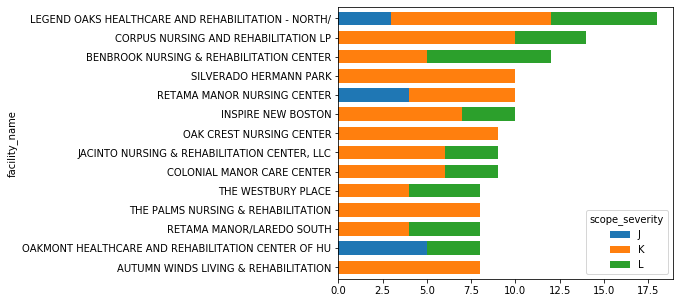

In [19]:
most_deficiencies.sort_values(by='sum').plot(x='facility_name', 
                                             y=['J', 'K', 'L'], 
                                             kind='barh',
                                             figsize=(6, 5),
                                             width=0.7,
                                             stacked=True, 
                                             title='')
plt.savefig('nursinghomes1.pdf')



In [20]:
!ls

Nursing Homes in Texas.ipynb        nursinghomes1.pdf
images                              penaltiestest.xlsx
index.html                          simple.html
inspection reports per facility.csv styles
nursing homes penalties.csv         ~$penaltiestest.xlsx


# Find total number of fines before and after Trump

In [21]:
texas_fines = pd.read_csv("nursing homes penalties.csv")

In [22]:
texas_fines.dtypes

provnum         int64
provname       object
address        object
city           object
zip             int64
pnlty_date     object
pnlty_type     object
fine_amt       object
Unnamed: 8    float64
Unnamed: 9    float64
dtype: object

## Drop the outlier from 2017 Q4

In [23]:
# texas_fines.loc[texas_fines['fine_amt'] == '1,254,213']
texas_fines = texas_fines.drop([894])

In [24]:
df = pd.DataFrame(columns=['2014 Q1', '2014 Q2', '2014 Q3', '2014 Q4', 
                           '2015 Q1', '2015 Q2', '2015 Q3', '2015 Q4',
                           '2016 Q1', '2016 Q2', '2016 Q3', '2016 Q4',
                           '2017 Q1', '2017 Q2', '2017 Q3', '2017 Q4',
                           '2018 Q1', '2018 Q2', '2018 Q3', '2018 Q4',], index=['0'])

In [25]:
texas_fines['fine_amt'] = texas_fines['fine_amt'].str.replace(',', '', regex=True)

In [26]:
texas_fines['fine_amt'] = texas_fines['fine_amt'].astype(int)

In [27]:
df['2014 Q1'] =texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/14'))].fine_amt.sum()

In [28]:
df['2014 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/14'))]['fine_amt'].sum()

In [29]:
df['2014 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/14'))]['fine_amt'].sum()

In [30]:
df['2014 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/14'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/14'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/14'))]['fine_amt'].sum()

/Users/elenamlutz/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [31]:
df['2015 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/15'))]['fine_amt'].sum()

In [32]:
df['2015 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/15'))]['fine_amt'].sum()

In [33]:
df['2015 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/15'))]['fine_amt'].sum()

In [34]:
df['2015 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/15'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/15'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/15'))]['fine_amt'].sum()

/Users/elenamlutz/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [35]:
df['2016 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/16'))]['fine_amt'].sum()

In [36]:
df['2016 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/16'))]['fine_amt'].sum()

In [37]:
df['2016 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/16'))]['fine_amt'].sum()

In [38]:
df['2016 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/16'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/16'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/16'))]['fine_amt'].sum()

/Users/elenamlutz/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [39]:
df['2017 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/17'))]['fine_amt'].sum()

In [40]:
df['2017 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/17'))]['fine_amt'].sum()

In [41]:
df['2017 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/17'))]['fine_amt'].sum()

In [42]:
df['2017 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/17'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/17'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/17'))]['fine_amt'].sum()

/Users/elenamlutz/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [43]:
df['2018 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/18'))]['fine_amt'].sum()

In [44]:
df['2018 Q2'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[4,5,6]/.*/18'))]['fine_amt'].sum()

In [45]:
df['2018 Q3'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[7,8,9]/.*/18'))]['fine_amt'].sum()

In [46]:
df['2018 Q4'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^(10)/.*/18'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(11)/.*/18'))]['fine_amt'].sum() + texas_fines[(texas_fines['pnlty_date'].str.contains('^(12)/.*/18'))]['fine_amt'].sum()

/Users/elenamlutz/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [47]:
df['2019 Q1'] = texas_fines[(texas_fines['pnlty_date'].str.contains('^[1,2,3]/.*/19'))]['fine_amt'].sum()

In [48]:
df.head()

,2014 Q1,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,...,2016 Q4,2017 Q1,2017 Q2,2017 Q3,2017 Q4,2018 Q1,2018 Q2,2018 Q3,2018 Q4,2019 Q1
0,863013,1005131,603364,606628,1344473,1396415,1391959,395146,1431867,1657746,...,738357,3463691,2973784,2257091,2037198,1879890,1753428,1165449,1061677,1091788


In [49]:
df = df.stack()

In [50]:
df=df.reset_index()

In [51]:
df=df.drop(['level_0'], axis=1)

In [52]:
df = df.rename(columns={'level_1': 'Quarter',
                        0: 'Total Fines'
                       })

In [53]:
df.head()

,Quarter,Total Fines
0,2014 Q1,863013
1,2014 Q2,1005131
2,2014 Q3,603364
3,2014 Q4,606628
4,2015 Q1,1344473


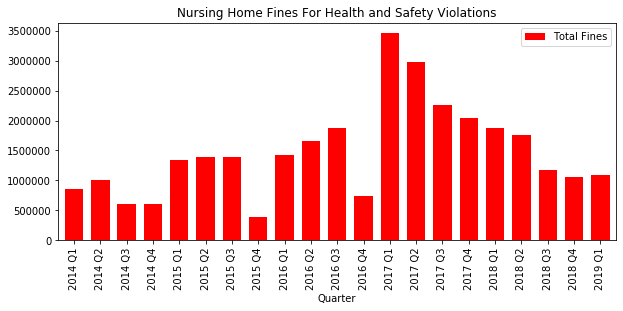

In [54]:
df.plot(x='Quarter',
        y=['Total Fines'],
        color='red',
        kind='bar',
        figsize=(10, 4),
        width=0.7,
        title='Nursing Home Fines For Health and Safety Violations')

plt.savefig('nursinghomes2.pdf')

# Find facilities with highest number of complaints

In [55]:
texas_deficiencies.head()

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text
17739,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,441,E,1,0,51U811,"><BR/>Based on observation, interview, and rec..."
17740,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,498,E,1,0,51U811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17741,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,224,E,1,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17742,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,226,E,1,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17743,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,248,E,0,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...


In [56]:
texas_deficiencies['complaint'] = texas_deficiencies.complaint.replace({1: 'yes', 0: 'no'})

/Users/elenamlutz/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [57]:
texas_complaints = texas_deficiencies[(texas_deficiencies['complaint']=='yes')]

In [58]:
texas_complaints = pd.DataFrame(texas_complaints.facility_name.value_counts().head(15))

In [59]:
texas_complaints=texas_complaints.reset_index()

In [60]:
texas_complaints=texas_complaints.rename(columns={'index': 'provname',
                                                  'facility_name': 'complaints'})
texas_complaints.head()

,provname,complaints
0,KENNEDY HEALTH & REHAB,52
1,THE WESTBURY PLACE,50
2,BRIARCLIFF NURSING AND REHABILITATION CENTER,48
3,OAK PARK NURSING AND REHABILITATION CENTER,46
4,CHELSEA GARDENS,46


In [61]:
texas_complaints['provname'] = texas_complaints['provname'].str.strip()

In [62]:
texas_fines.head()

,provnum,provname,address,city,zip,pnlty_date,pnlty_type,fine_amt,Unnamed: 8,Unnamed: 9
0,455497,CREEKSIDE TERRACE REHABILITATION,1555 POWELL AVENUE,BELTON,76513,1/2/15,Fine,5525,NaN,NaN
1,675056,STANTON NURSING AND REHABILITATION LP,1100 W BROADWAY,STANTON,79782,1/8/15,Fine,7670,NaN,NaN
2,455678,SUMMER MEADOWS,301 HOLLYBROOK DR,LONGVIEW,75605,1/15/15,Fine,1268,NaN,NaN
3,675501,HERITAGE OAKS WEST RETIREMENT VILLAGE,3300 W 2ND AVE,CORSICANA,75110,1/15/15,Fine,1300,NaN,NaN
4,675793,BROOKHOLLOW HEIGHTS TRANSITIONAL CARE CENTER,1737 N LOOP W,HOUSTON,77008,1/16/15,Fine,239655,NaN,NaN


# Find facilities with most fines issued against them

In [63]:
most_fines = pd.DataFrame(texas_fines.groupby('provname').fine_amt.sum().sort_values(ascending=False).head(15))

In [64]:
most_fines = most_fines.reset_index()

In [65]:
most_fines.head()

,provname,fine_amt
0,NORTH POINTE NURSING AND REHABILITATION LP,470615
1,REGAL HEALTHCARE RESIDENCE,453128
2,COPPERAS HOLLOW NURSING & REHABILITATION CENTER,430564
3,RIDGEVIEW REHABILITATION AND SKILLED NURSING,392217
4,PITTSBURG NURSING CENTER,358142


In [66]:
most_fines['provname'] = most_fines['provname'].str.strip()

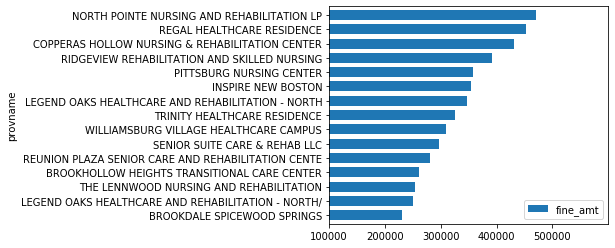

In [67]:
ax2 = most_fines.sort_values(by='fine_amt').plot(x='provname',
                      y='fine_amt',
                      kind='barh',
                      figsize=(5, 4),
                      width=0.7)
ax2.set_xticks([100000, 200000, 300000, 400000, 500000])
ax2.set_xlim(100000,600000)

plt.savefig('nursinghomes5.pdf')

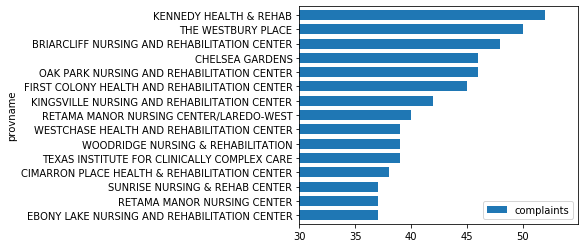

In [84]:
ax = texas_complaints.sort_values(by='complaints').plot(x='provname',
                      y='complaints',
                      kind='barh',
                      figsize=(5, 4),
                      width=0.7)
ax.set_xticks([30, 35, 40, 45, 50])
ax.set_xlim(30,55)

plt.savefig('nursinghomes4.pdf')

# Scatterplot of fines

In [68]:
!ls

Nursing Homes in Texas.ipynb        nursinghomes2.pdf
images                              nursinghomes5.pdf
index.html                          penaltiestest.xlsx
inspection reports per facility.csv simple.html
nursing homes penalties.csv         styles
nursinghomes1.pdf                   ~$penaltiestest.xlsx


In [69]:
df3 = pd.read_excel("penaltiestest.xlsx")

In [70]:
df3.head()

,provnum,provname,address,city,zip,scatter,pnlty_date,pnlty_type,fine_amt
0,675210,HERITAGE HOUSE NURSING AND REHABILITATION,407 N COLLEGE ST,ROSEBUD,76570,1,2014-01-10,Fine,1744
1,676220,GRANITE MESA HEALTH CENTER,1401 MAX COPELAND DR,MARBLE FALLS,78654,1,2014-01-10,Fine,3500
2,676220,GRANITE MESA HEALTH CENTER,1401 MAX COPELAND DR,MARBLE FALLS,78654,1,2014-01-10,Fine,2000
3,676052,IMMANUELS HEALTHCARE,4515 VILLAGE CREEK RD,FORT WORTH,76119,2,2014-01-11,Fine,115011
4,675939,VINTAGE HEALTH CARE CENTER,205 N BONNIE BRAE,DENTON,76201,3,2014-01-15,Fine,1300


In [71]:
df3['pnlty_date'] = df3.pnlty_date.astype(str)

In [72]:
df3['pnlty_date'] = df3.pnlty_date.str.replace('-\d\d-\d\d', '', regex=True)

In [73]:
df3['pnlty_date'] = df3.pnlty_date.astype(int)

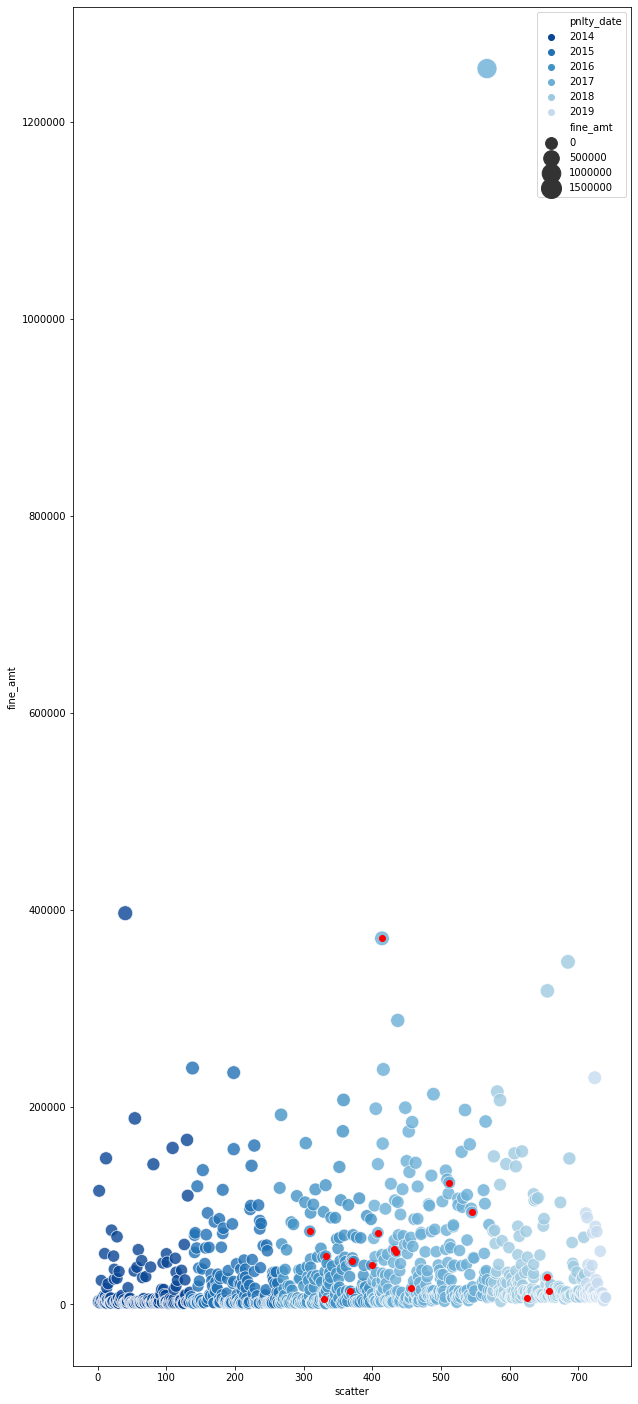

In [90]:
colors = ['#084594', '#2171b5', '#4292c6', '#6baed6', '#9ecae1', '#c6dbef']
fig, ax = plt.subplots(figsize=(10, 25))
chart = sns.scatterplot(x="scatter", 
                        y="fine_amt", 
                        size="fine_amt",
                        palette=colors,
                        sizes=(140, 400),
                        hue = 'pnlty_date',
                        alpha=0.8,
                        data=df3,
                        ax=ax)
plt.scatter(x=655, y=27701, color='r')
plt.scatter(x=512, y=123404, color='r')
plt.scatter(x=545, y=93053, color='r')
plt.scatter(x=309, y=73933, color='r')
plt.scatter(x=408, y= 72508 , color='r')
plt.scatter(x=431, y=55646, color='r')
plt.scatter(x=435, y=53057, color='r')
plt.scatter(x=332, y= 48815 , color='r')
plt.scatter(x=399, y=39550, color='r')
plt.scatter(x=371, y=43692, color='r')
plt.scatter(x=457, y= 16139 , color='r')
plt.scatter(x=658, y=13328, color='r')
plt.scatter(x=368, y=13244, color='r')
plt.scatter(x=625, y=6500, color='r')
plt.scatter(x=329, y=5525, color='r')
plt.scatter(x=414, y=371287, color='r')


plt.savefig("scatterplot.pdf")

In [85]:
texas_deficiencies.head()

,facility_name,facility_id,address,city,state,zip,inspection_date,deficiency_tag,scope_severity,complaint,standard,eventid,inspection_text
17739,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,441,E,yes,0,51U811,"><BR/>Based on observation, interview, and rec..."
17740,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,12/08/2016,498,E,yes,0,51U811,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17741,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,224,E,yes,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17742,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,226,E,yes,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...
17743,PHP THE OAKS AT BEAUMONT,455001,4195 MILAM ST,BEAUMONT,TX,77707,04/26/2017,248,E,no,1,DHMS11,**NOTE- TERMS IN BRACKETS HAVE BEEN EDITED TO ...


In [88]:
texas_deficiencies.groupby(['city']).scope_severity.count().sort_values(ascending=False)

city
SAN ANTONIO         2119
HOUSTON             1778
FORT WORTH           624
CORPUS CHRISTI       601
EL PASO              556
DALLAS               531
LUBBOCK              429
AUSTIN               420
TYLER                338
MCALLEN              338
BROWNSVILLE          337
LONGVIEW             288
AMARILLO             243
HARLINGEN            232
TEXARKANA            232
BEAUMONT             224
ABILENE              205
WACO                 203
LAREDO               194
NEW BRAUNFELS        190
KATY                 181
TEXAS CITY           181
MISSOURI CITY        176
PASADENA             173
BOERNE               170
MIDLAND              169
ARLINGTON            162
EDINBURG             155
BAYTOWN              152
PARIS                150
                    ... 
NOCONA                 8
HUNTINGTON             8
DRIPPING SPRINGS       8
FORNEY                 8
FRANKLIN               8
ALVARADO               8
HICO                   7
BRONTE                 7
HENRIETTA           

# Map out cities with most deficiencies

In [276]:
csvforgeocodio = pd.DataFrame(texas_deficiencies.groupby(['address', 'city', 'state', 'zip']).scope_severity.count())

In [281]:
csvforgeocodio = csvforgeocodio.reset_index()

In [283]:
csvforgeocodio.head()

,address,city,state,zip,scope_severity
0,100 GAY ST,MENARD,TX,76859,11
1,100 HERMANN DR,DEL RIO,TX,78840,18
2,100 N E LOOP 304,CROCKETT,TX,75835,11
3,1000 AVE J,LAMPASAS,TX,76550,51
4,1000 E MAIN ST,ROUND ROCK,TX,78664,9


In [284]:
csvforgeocodio.to_csv('csvforgeocodio.csv', index=False)